# Proyecto CBIR
---
Autores: Claudio Acevedo y Vicente Pedreros

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## 0.- Ordenamiento de datos

En esta sección se cargan las imágenes y se separan en imágenes de la base de datos e imágenes de consulta

In [2]:
path_gpr = "GPR1200/"
path_inria = "INRIA/"

id_files_gpr = os.listdir(path_gpr)
id_files_gpr = [f for f in id_files_gpr if os.path.isfile(path_gpr+'/'+f)]

id_files_inria = os.listdir(path_inria)
id_files_inria = [f for f in id_files_inria if os.path.isfile(path_inria+'/'+f)]

print(f'En la base de datos GPR existen {len(id_files_gpr)} archivos')
print(f'En la base de datos INRIA existen {len(id_files_inria)} archivos')

En la base de datos GPR existen 12000 archivos
En la base de datos INRIA existen 1491 archivos


In [3]:
# Se crea base de datos
id_database = [f for f in id_files_inria if f[4:6] != '00']

# Se crea imágenes de consulta
id_consult_inria = [f for f in id_files_inria if f[4:6] == '00']
id_consult = id_consult_inria + id_files_gpr

print(f'Hay {len(id_database)} archivos en la base de datos')
print(f'Hay {len(id_consult)} archivos de consulta')

Hay 991 archivos en la base de datos
Hay 12500 archivos de consulta


In [4]:
# Se crean listas con las imágenes en ellas
database = [cv2.imread(path_inria + f) for f in id_database]

consult_inria = [cv2.imread(path_inria + f) for f in id_consult_inria]
consult_gpr = [cv2.imread(path_gpr + f) for f in id_files_gpr]

consult = consult_inria + consult_gpr

In [5]:
# Se crean listas con las imágenes en ellas
database_gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in database]

consult_inria_gray= [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in consult_inria]
consult_gpr_gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in consult_gpr]

consult_gray = consult_inria_gray + consult_gpr_gray

In [6]:
# Se regularizan los tamaños de las imágenes

database_gray = [cv2.resize(img, (500,400), interpolation=cv2.INTER_LINEAR) for img in database_gray]
consult_gray = [cv2.resize(img, (500,400), interpolation=cv2.INTER_LINEAR) for img in consult_gray]

In [7]:
def imshow(img):
    """Se define esta función para graficar localmente"""
    figure, axis = plt.subplots()
    axis.axis('off')
    axis.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 1.- Cálculo de vector de características

### HOG

In [8]:
def HOG_hist(img):
    grad_x, grad_y = np.gradient(img, axis=1), np.gradient(img, axis=0)
    # dimensiones celda
    fila, col = img.shape[0] // 8, img.shape[1] // 8
    largo_rango_ang = 20
    output = np.zeros((8, 8, 180 // largo_rango_ang), dtype='float32')

    for i in range(8):
        for j in range(8):
            # origen de la celda
            f0, c0 = fila * i, col * j
            histograma = np.zeros(180 // largo_rango_ang)

            for f in range(fila):
                for c in range(col):
                    angulo = np.rad2deg(np.arctan2(grad_y[f0+f, c0+c], grad_x[f0+f, c0+c])) % 180
                    idx = int(angulo / largo_rango_ang)
                    histograma[idx] += np.sqrt(grad_x[f0+f,c0+c]**2 + grad_y[f0+f,c0+c]**2)
            output[i,j] = histograma
    return output

In [9]:
def HOG_get_features(img):
    hist = HOG_hist(img)
    filas = hist.shape[0]
    cols = hist.shape[1]

    output = []
    for i in range(filas-1):
        for j in range(cols-1):
            bloque = hist[i:i+2,j:j+2].flatten()
            if np.max(np.abs(bloque)) != 0:
                bloque = bloque / np.max(np.abs(bloque))
            output.append(bloque)
    output = np.array(output).flatten()
    normalizacion = np.sqrt(np.square(output).sum())
    return output / normalizacion
    

In [10]:
HOG_features_db = []

for idx, img in enumerate(database_gray):
    print("Img number: %i" % idx, end = '\r')
    HOG_features_db.append(HOG_get_features(img))

HOG_features_db = np.array(HOG_features_db)
np.save('HOG_features_db.npy', HOG_features_db)

In [11]:
HOG_features_db = np.load('HOG_features_db.npy')

### CNN
Se usará VGG16 desde pytorch

In [12]:
import torch, torchvision
from torchvision import models, transforms

In [13]:
transform =   transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
model.classifier = model.classifier[:-1] # 4096 features instead of 1000
model.eval();

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def CNN_get_features(img):
    # se extraen caracteristicas
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t,0)
    feature = model(batch_t).detach().numpy()[0]
    return feature

In [16]:
# se extren las características de cada imagen y se guardan en X
CNN_features_db = []

# se recorre cada imagen

for idx, img in enumerate(database):
    print("Img number: %i" % idx, end = '\r')
    # se agrega al conjunto de caracteristicas
    CNN_features_db.append(CNN_get_features(img))

# se guarda el arreglo
CNN_features_db = np.array(CNN_features_db)
np.save('CNN_features_db.npy', CNN_features_db)
print(f'{CNN_features_db.shape[0]} características extraidas exitosamente')

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


991 características extraidas exitosamente


In [17]:
CNN_features_db = np.load('CNN_features_db.npy')

## 2.- Medida de Similitud

In [18]:
def medida_similitud(x, y):
    output = np.linalg.norm(x - y)
    return output

## 3.- Ordenar resultados por relevancia

In [19]:
def busqueda(img_idx, method, size=5):
    if method == 'HOG':
        features = HOG_get_features(consult_gray[img_idx])
        comparaciones = np.zeros(len(HOG_features_db), dtype = 'float32')

        for i, data_feature in enumerate(HOG_features_db):
            comparaciones[i] = medida_similitud(features, data_feature)

    elif method == 'CNN':
        features = CNN_get_features(consult[img_idx])
        comparaciones = np.zeros(len(CNN_features_db), dtype = 'float32')
        for i, data_feature in enumerate(CNN_features_db):
              comparaciones[i] = medida_similitud(features, data_feature)
        comparaciones = comparaciones / np.max(comparaciones)

    else: 
        print('Metodo invalido')

    # indices mas parecidos
    idxs = np.argsort(comparaciones)[:size]

    # se muestra la imagen original
    print('Original: ', id_consult[img_idx])
    imshow(consult[img_idx])

    # se muestran las mas parecidas en orden
    for idx in idxs:
        img = database[idx]
        print(id_database[idx])
        imshow(img)
    
    return idxs, [comparaciones[i] for i in idxs]

Original:  113200.jpg
113201.jpg
134402.jpg
134403.jpg
140601.jpg
114801.jpg


(array([394, 964, 966,  45, 490]),
 [0.35172138, 0.39687145, 0.41353875, 0.414617, 0.41646114])

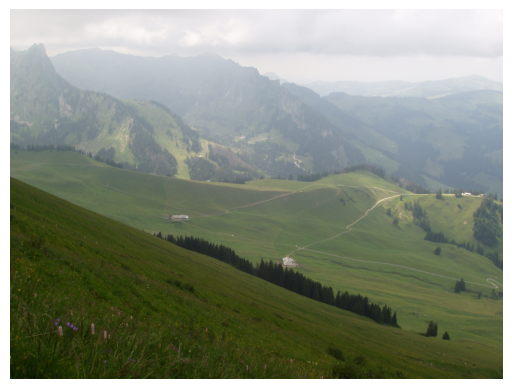

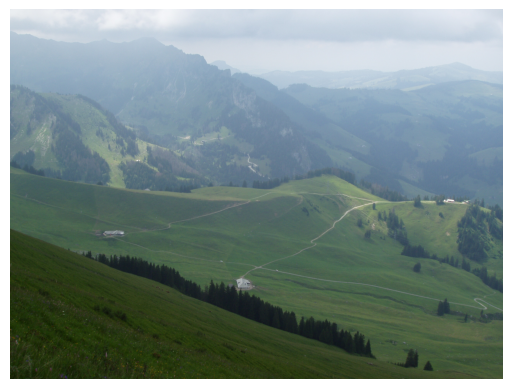

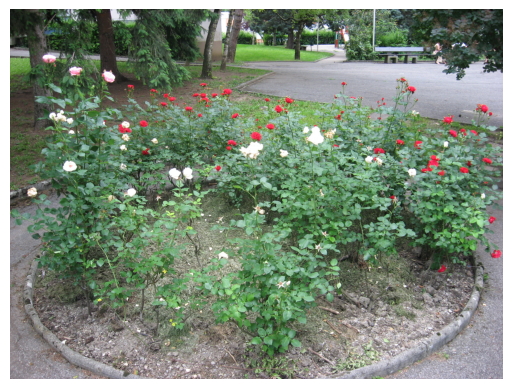

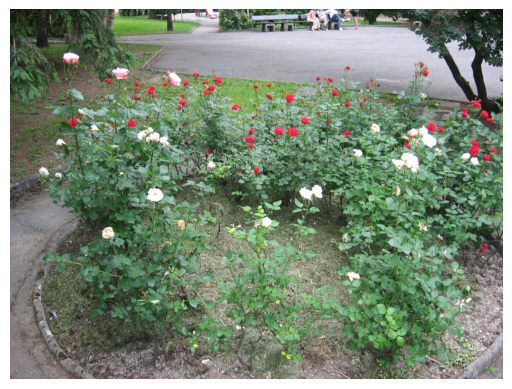

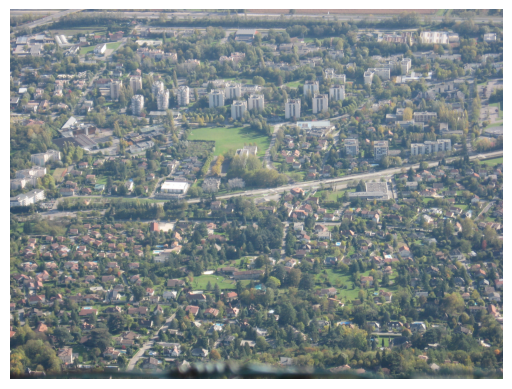

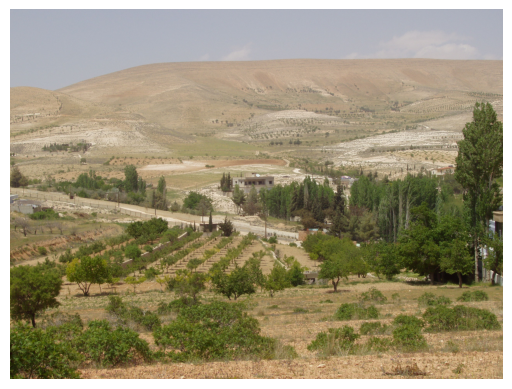

In [34]:
busqueda(206, 'HOG')

## 4.- Medida de ranking

In [21]:
def rank(idx_img_consulta):
    # se encuentran las clases
    id = id_consult[idx_img_consulta]
    if '_' in id:
        clase = id.partition('_')[0]
    else:
        clase = id[:3]
    idxs = [i for i in id_consult if clase in i]
    N_rel = id_consult.count(clase)
    comparaciones = np.argsort(busqueda(idx_img_consulta)[0])
    
    

In [22]:
a = ['1', '2', '3', '4', '5', '6','2']

In [23]:
a.count('2')

2